# **MLP MODEL**

Epoch 1/15, Loss: 0.6895, Accuracy: 77.90%
Epoch 2/15, Loss: 0.3547, Accuracy: 89.02%
Epoch 3/15, Loss: 0.2864, Accuracy: 90.99%
Epoch 4/15, Loss: 0.2243, Accuracy: 93.13%
Epoch 5/15, Loss: 0.2112, Accuracy: 93.53%
Epoch 6/15, Loss: 0.1965, Accuracy: 94.10%
Epoch 7/15, Loss: 0.1733, Accuracy: 94.62%
Epoch 8/15, Loss: 0.1653, Accuracy: 94.93%
Epoch 9/15, Loss: 0.1556, Accuracy: 95.31%
Epoch 10/15, Loss: 0.1497, Accuracy: 95.41%
Epoch 11/15, Loss: 0.1454, Accuracy: 95.67%
Epoch 12/15, Loss: 0.1394, Accuracy: 95.72%
Epoch 13/15, Loss: 0.1384, Accuracy: 95.78%
Epoch 14/15, Loss: 0.1347, Accuracy: 95.91%
Epoch 15/15, Loss: 0.1280, Accuracy: 96.09%


<ipython-input-5-4f342bada9fd>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mnist_model.pth"))


Test Accuracy: 98.78%


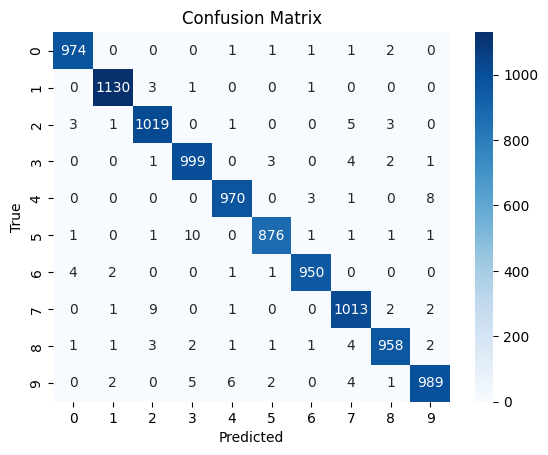

Classification Report:
              precision    recall  f1-score   support

           0  0.9908443540 0.9938775510 0.9923586347       980
           1  0.9938434477 0.9955947137 0.9947183099      1135
           2  0.9835907336 0.9874031008 0.9854932302      1032
           3  0.9823008850 0.9891089109 0.9856931426      1010
           4  0.9887869521 0.9877800407 0.9882832399       982
           5  0.9909502262 0.9820627803 0.9864864865       892
           6  0.9926854754 0.9916492693 0.9921671018       958
           7  0.9806389158 0.9854085603 0.9830179525      1028
           8  0.9886480908 0.9835728953 0.9861039629       974
           9  0.9860418744 0.9801783944 0.9831013917      1009

    accuracy                      0.9878000000     10000
   macro avg  0.9878330955 0.9876636217 0.9877423453     10000
weighted avg  0.9878094682 0.9878000000 0.9877989022     10000



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class EnhancedMLP(nn.Module):
    def __init__(self):
        super(EnhancedMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)
        return x

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = EnhancedMLP().to(device)
model.apply(initialize_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

epochs = 15
best_accuracy = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()
    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_mnist_model.pth")

model.load_state_dict(torch.load("best_mnist_model.pth"))
model.eval()

correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=10))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5 images.


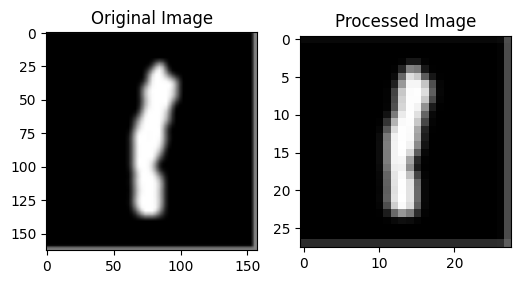

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105309.png, Predicted Class: 1


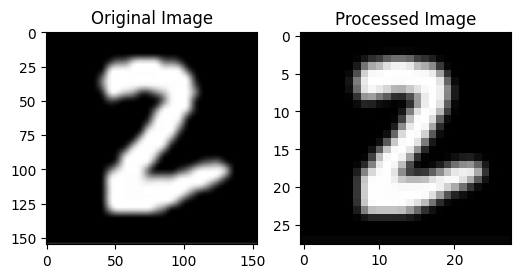

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105316.png, Predicted Class: 1


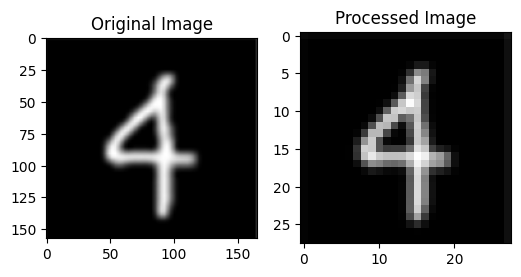

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105322.png, Predicted Class: 1


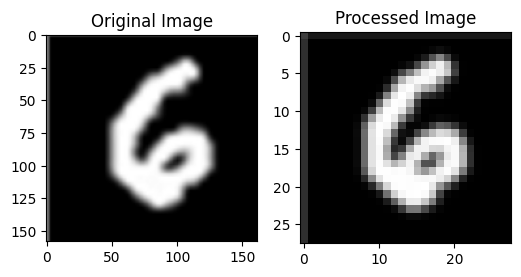

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105425.png, Predicted Class: 6


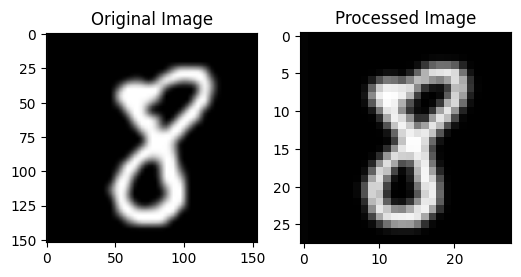

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105434.png, Predicted Class: 1


In [ ]:
from google.colab import drive
import os
import cv2
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


drive.mount('/content/drive')


test_images_folder = '/content/drive/My Drive/test_images'


image_files = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_files)} images.")


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


def test_single_image(image_path, model, transform):

    model.eval()


    image = Image.open(image_path).convert('RGB')
    original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


    processed_image = transform(image).unsqueeze(0).to(device)


    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Processed Image")
    plt.show()


    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)

    return original_image, predicted.item()


model.eval()
for image_path in image_files:
    original_image, predicted_class = test_single_image(image_path, model, transform)
    print(f"Image: {image_path}, Predicted Class: {predicted_class}")


# **CNN MODEL**

Epoch 1/15, Loss: 0.1181, Accuracy: 96.73%
Epoch 2/15, Loss: 0.0500, Accuracy: 98.44%
Epoch 3/15, Loss: 0.0391, Accuracy: 98.85%
Epoch 4/15, Loss: 0.0302, Accuracy: 99.06%
Epoch 5/15, Loss: 0.0263, Accuracy: 99.17%
Epoch 6/15, Loss: 0.0232, Accuracy: 99.28%
Epoch 7/15, Loss: 0.0187, Accuracy: 99.41%
Epoch 8/15, Loss: 0.0164, Accuracy: 99.48%
Epoch 9/15, Loss: 0.0163, Accuracy: 99.45%
Epoch 10/15, Loss: 0.0143, Accuracy: 99.56%
Epoch 11/15, Loss: 0.0120, Accuracy: 99.62%
Epoch 12/15, Loss: 0.0104, Accuracy: 99.66%
Epoch 13/15, Loss: 0.0138, Accuracy: 99.55%
Epoch 14/15, Loss: 0.0093, Accuracy: 99.68%
Epoch 15/15, Loss: 0.0103, Accuracy: 99.66%
Test Accuracy: 99.24%


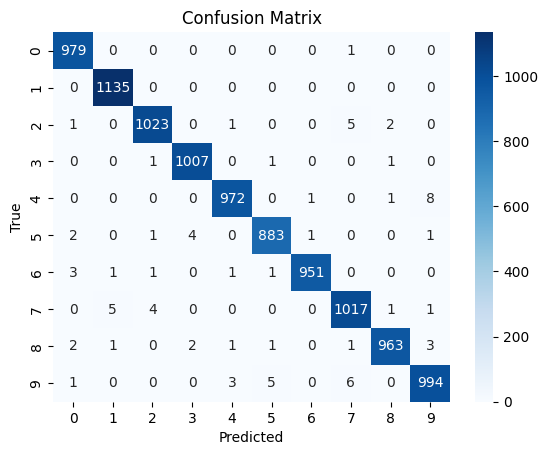

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Overall Metrics:
Accuracy: 0.99240000000
Precision: 0.99240443784
Recall: 0.99240000000
F1 Score: 0.99239701872


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0.5 and std 0.5
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        # Activation, dropout, and batch normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


# Instantiate the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 15
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

# Testing loop
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))

# Overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Overall Metrics:\nAccuracy: {accuracy:.11f}\nPrecision: {precision:.11f}\nRecall: {recall:.11f}\nF1 Score: {f1:.11f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5 images.


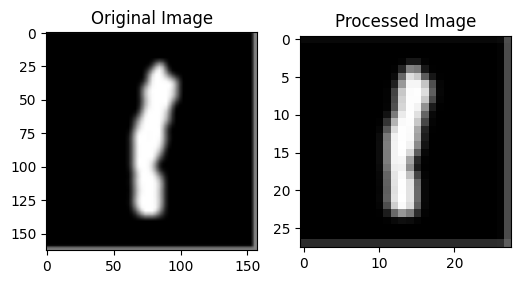

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105309.png, Predicted Class: 1


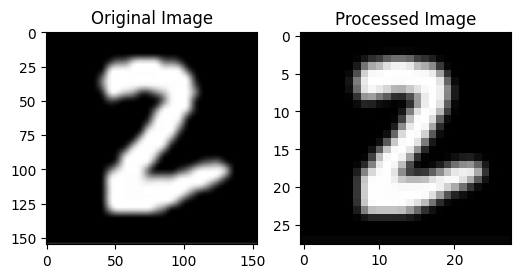

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105316.png, Predicted Class: 2


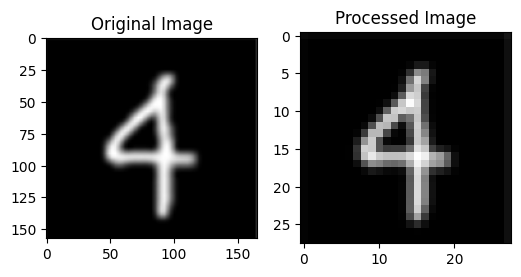

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105322.png, Predicted Class: 4


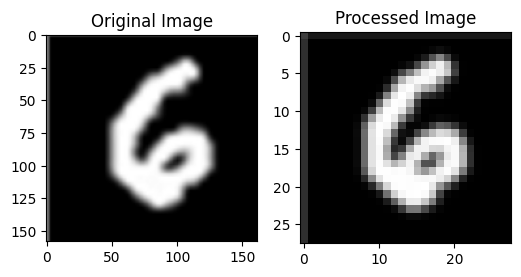

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105425.png, Predicted Class: 6


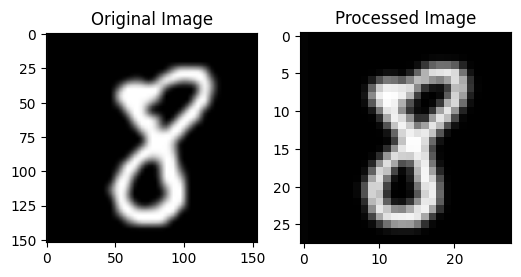

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105434.png, Predicted Class: 8


In [ ]:
from google.colab import drive
import os
import cv2
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Define test images folder path
test_images_folder = '/content/drive/My Drive/test_images'

# Load all image file paths
image_files = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_files)} images.")

# Define normalization techniques
normalization_options = {
    'zero_one': transforms.Normalize((0.0,), (1.0,)),  # Scale [0, 1]
    'minus_one_one': transforms.Normalize((0.5,), (0.5,)),  # Scale [-1, 1]
    'mean_std': transforms.Normalize((0.5,), (0.25,))  # Custom mean and std deviation
}

# Choose the normalization technique
selected_normalization = normalization_options['minus_one_one']  # Change this to test others

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    selected_normalization
])

# Function to test a single image
def test_single_image(image_path, model, transform):
    # Set model to evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Apply transformations
    processed_image = transform(image).unsqueeze(0).to(device)

    # Display original and processed images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Processed Image")
    plt.show()

    # Perform inference
    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)

    return original_image, predicted.item()

# Loop through and test each image
model.eval()
for image_path in image_files:
    original_image, predicted_class = test_single_image(image_path, model, transform)
    print(f"Image: {image_path}, Predicted Class: {predicted_class}")



# **LENET 5**

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 52.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.17MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.03MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training with Learning Rate: 0.01, Batch Size: 32
Epoch 1/10, Loss: 0.7183, Accuracy: 77.90%
Epoch 2/10, Loss: 0.5025, Accuracy: 85.88%
Epoch 3/10, Loss: 0.4798, Accuracy: 86.75%
Epoch 4/10, Loss: 0.4802, Accuracy: 86.91%
Epoch 5/10, Loss: 0.4898, Accuracy: 86.85%
Epoch 6/10, Loss: 0.4661, Accuracy: 87.63%
Epoch 7/10, Loss: 0.4761, Accuracy: 87.58%
Epoch 8/10, Loss: 0.4624, Accuracy: 87.86%
Epoch 9/10, Loss: 0.4647, Accuracy: 87.93%
Epoch 10/10, Loss: 0.4552, Accuracy: 88.16%
Test Accuracy: 97.19%



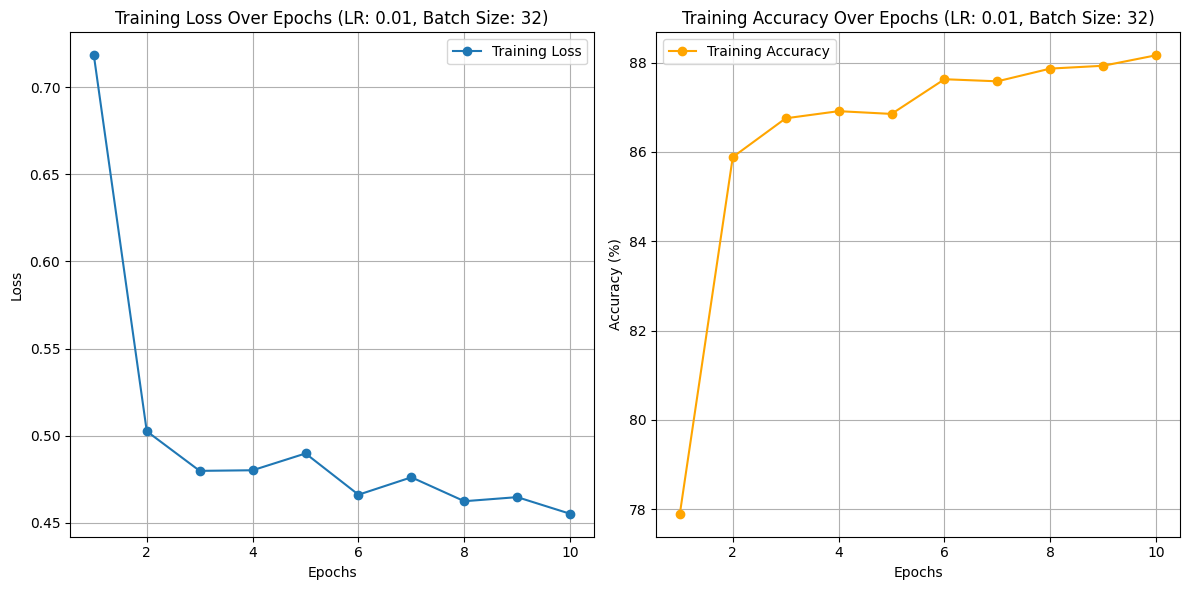

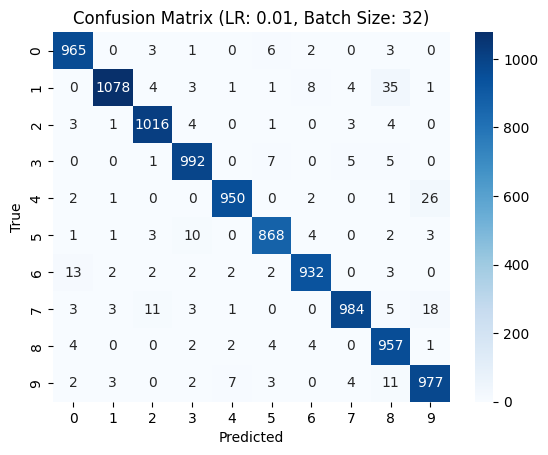

Classification Report (LR: 0.01, Batch Size: 32):
              precision    recall  f1-score   support

           0  0.97180262 0.98469388 0.97820578       980
           1  0.98989899 0.94977974 0.96942446      1135
           2  0.97692308 0.98449612 0.98069498      1032
           3  0.97350343 0.98217822 0.97782159      1010
           4  0.98650052 0.96741344 0.97686375       982
           5  0.97309417 0.97309417 0.97309417       892
           6  0.97899160 0.97286013 0.97591623       958
           7  0.98400000 0.95719844 0.97041420      1028
           8  0.93274854 0.98254620 0.95700000       974
           9  0.95224172 0.96828543 0.96019656      1009

    accuracy                      0.97190000     10000
   macro avg  0.97197047 0.97225458 0.97196317     10000
weighted avg  0.97228034 0.97190000 0.97193655     10000

Training with Learning Rate: 0.01, Batch Size: 64
Epoch 1/10, Loss: 0.5969, Accuracy: 81.58%
Epoch 2/10, Loss: 0.3931, Accuracy: 88.85%
Epoch 3/10, Loss: 

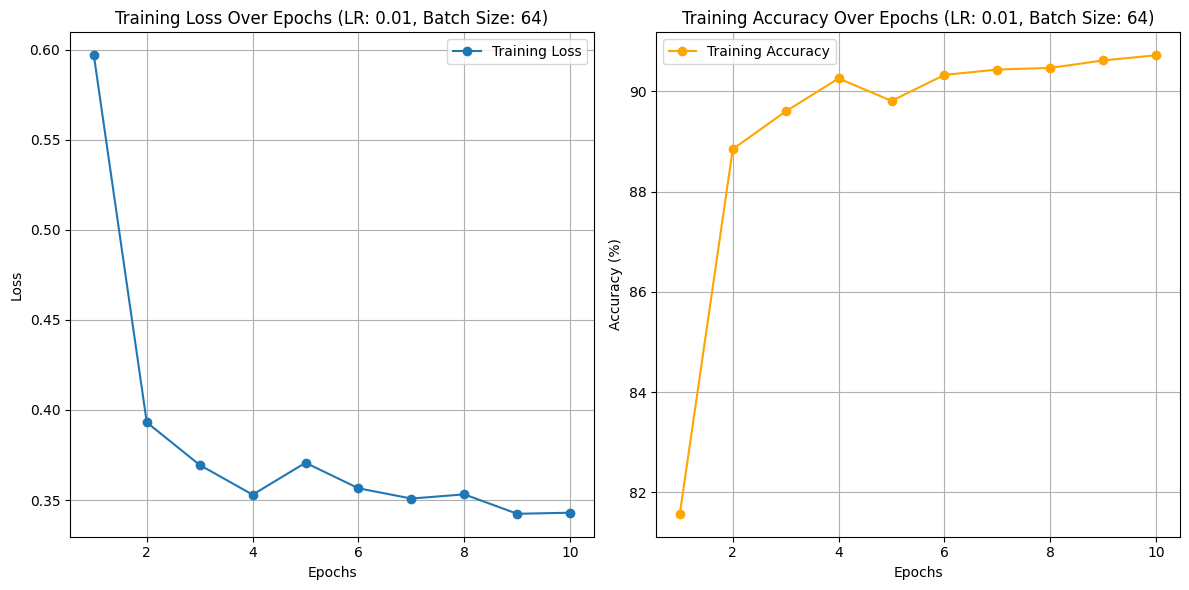

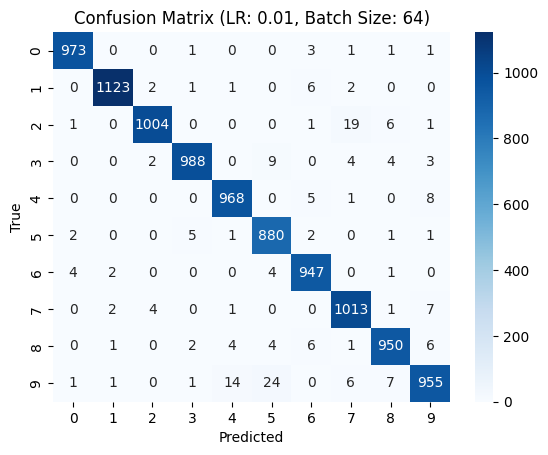

Classification Report (LR: 0.01, Batch Size: 64):
              precision    recall  f1-score   support

           0  0.99184506 0.99285714 0.99235084       980
           1  0.99468556 0.98942731 0.99204947      1135
           2  0.99209486 0.97286822 0.98238748      1032
           3  0.98997996 0.97821782 0.98406375      1010
           4  0.97876643 0.98574338 0.98224252       982
           5  0.95548317 0.98654709 0.97076669       892
           6  0.97628866 0.98851775 0.98236515       958
           7  0.96752627 0.98540856 0.97638554      1028
           8  0.97837281 0.97535934 0.97686375       974
           9  0.97250509 0.94648167 0.95931693      1009

    accuracy                      0.98010000     10000
   macro avg  0.97975479 0.98014283 0.97987921     10000
weighted avg  0.98022318 0.98010000 0.98009405     10000

Training with Learning Rate: 0.01, Batch Size: 128
Epoch 1/10, Loss: 0.6697, Accuracy: 78.87%
Epoch 2/10, Loss: 0.3806, Accuracy: 88.84%
Epoch 3/10, Loss:

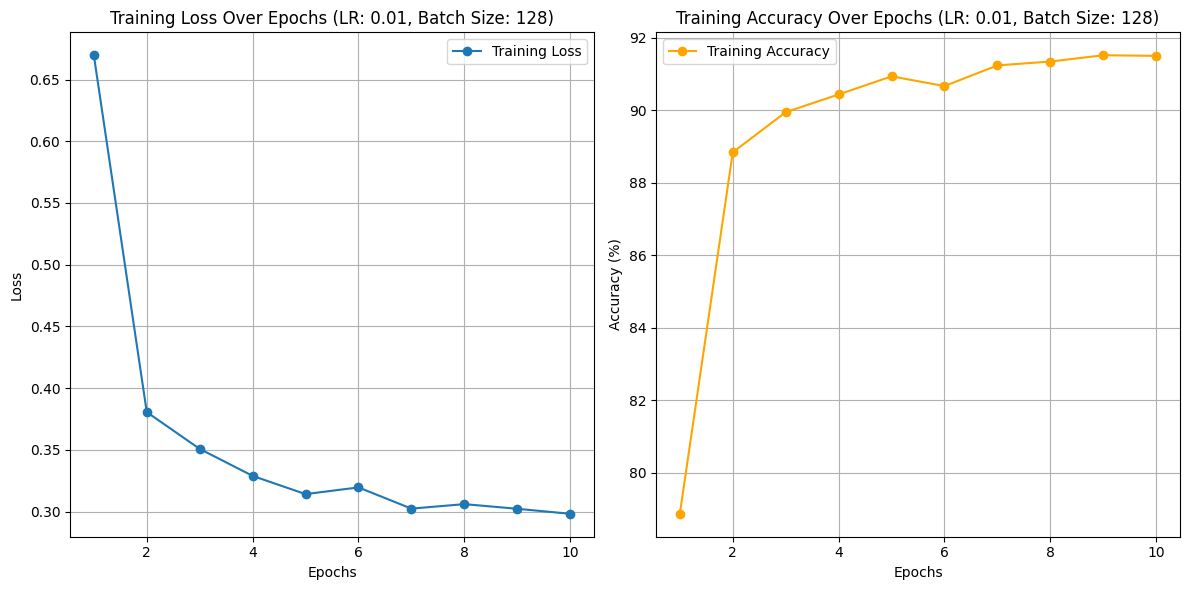

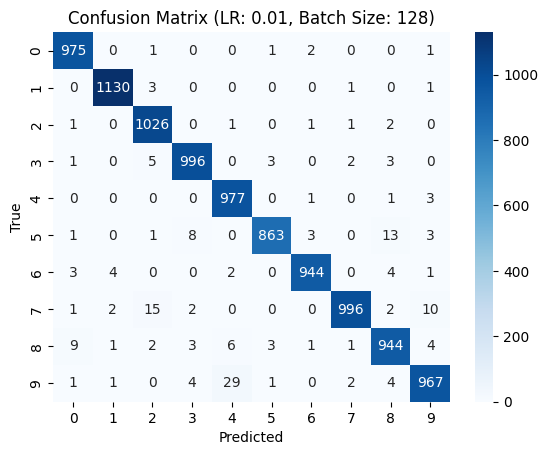

Classification Report (LR: 0.01, Batch Size: 128):
              precision    recall  f1-score   support

           0  0.98286290 0.99489796 0.98884381       980
           1  0.99297012 0.99559471 0.99428069      1135
           2  0.97435897 0.99418605 0.98417266      1032
           3  0.98321816 0.98613861 0.98467622      1010
           4  0.96256158 0.99490835 0.97846770       982
           5  0.99081515 0.96748879 0.97901305       892
           6  0.99159664 0.98538622 0.98848168       958
           7  0.99302094 0.96887160 0.98079764      1028
           8  0.97019527 0.96919918 0.96969697       974
           9  0.97676768 0.95837463 0.96748374      1009

    accuracy                      0.98180000     10000
   macro avg  0.98183674 0.98150461 0.98159142     10000
weighted avg  0.98191620 0.98180000 0.98178010     10000

Training with Learning Rate: 0.001, Batch Size: 32
Epoch 1/10, Loss: 0.7087, Accuracy: 76.78%
Epoch 2/10, Loss: 0.3273, Accuracy: 90.12%
Epoch 3/10, Loss

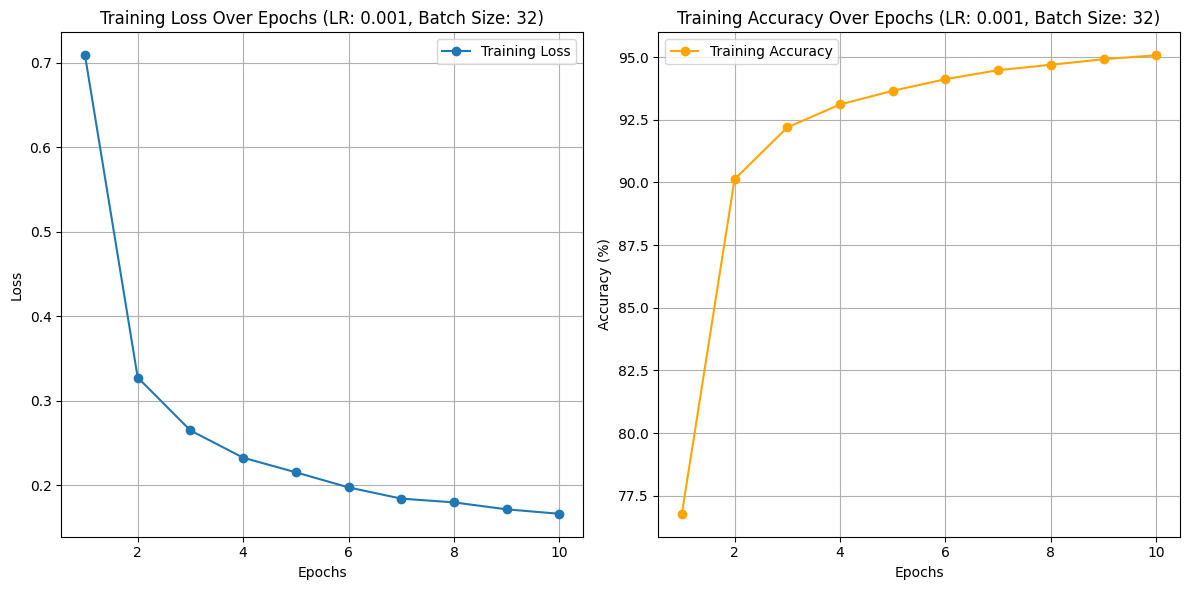

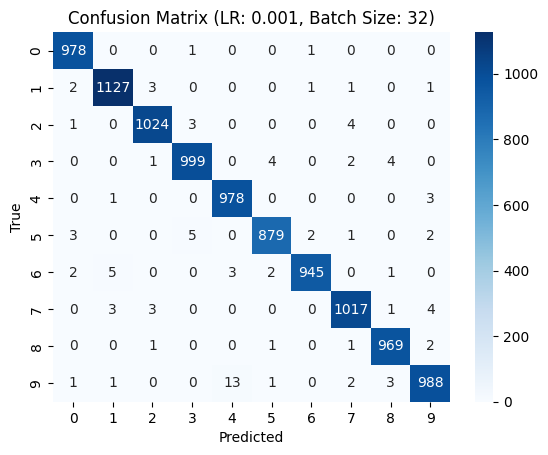

Classification Report (LR: 0.001, Batch Size: 32):
              precision    recall  f1-score   support

           0  0.99088146 0.99795918 0.99440773       980
           1  0.99120493 0.99295154 0.99207746      1135
           2  0.99224806 0.99224806 0.99224806      1032
           3  0.99107143 0.98910891 0.99008920      1010
           4  0.98390342 0.99592668 0.98987854       982
           5  0.99098083 0.98542601 0.98819562       892
           6  0.99578504 0.98643006 0.99108547       958
           7  0.98929961 0.98929961 0.98929961      1028
           8  0.99079755 0.99486653 0.99282787       974
           9  0.98800000 0.97918731 0.98357392      1009

    accuracy                      0.99040000     10000
   macro avg  0.99041723 0.99034039 0.99036835     10000
weighted avg  0.99041025 0.99040000 0.99039491     10000

Training with Learning Rate: 0.001, Batch Size: 64
Epoch 1/10, Loss: 0.8673, Accuracy: 70.79%
Epoch 2/10, Loss: 0.3736, Accuracy: 88.50%
Epoch 3/10, Loss

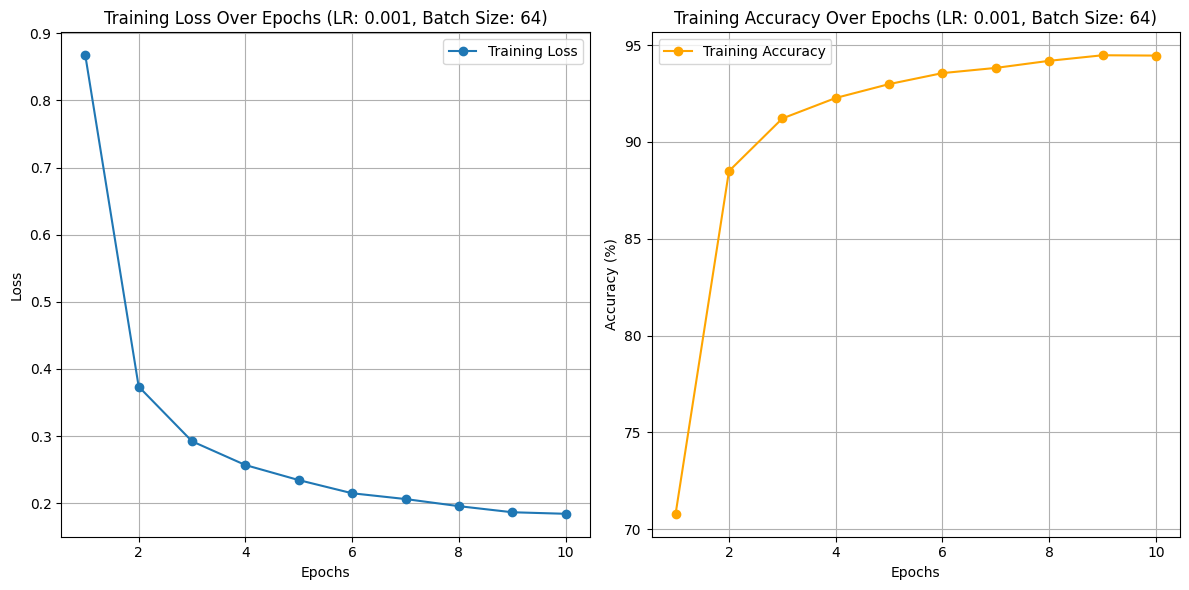

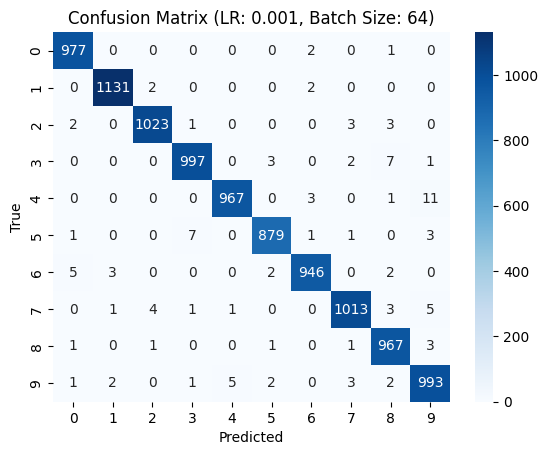

Classification Report (LR: 0.001, Batch Size: 64):
              precision    recall  f1-score   support

           0  0.98986829 0.99693878 0.99339095       980
           1  0.99472296 0.99647577 0.99559859      1135
           2  0.99320388 0.99127907 0.99224054      1032
           3  0.99006951 0.98712871 0.98859693      1010
           4  0.99383350 0.98472505 0.98925831       982
           5  0.99098083 0.98542601 0.98819562       892
           6  0.99161426 0.98747390 0.98953975       958
           7  0.99022483 0.98540856 0.98781082      1028
           8  0.98073022 0.99281314 0.98673469       974
           9  0.97736220 0.98414272 0.98074074      1009

    accuracy                      0.98930000     10000
   macro avg  0.98926105 0.98918117 0.98921069     10000
weighted avg  0.98932448 0.98930000 0.98930204     10000

Training with Learning Rate: 0.001, Batch Size: 128
Epoch 1/10, Loss: 0.9322, Accuracy: 68.53%
Epoch 2/10, Loss: 0.4295, Accuracy: 86.83%
Epoch 3/10, Los

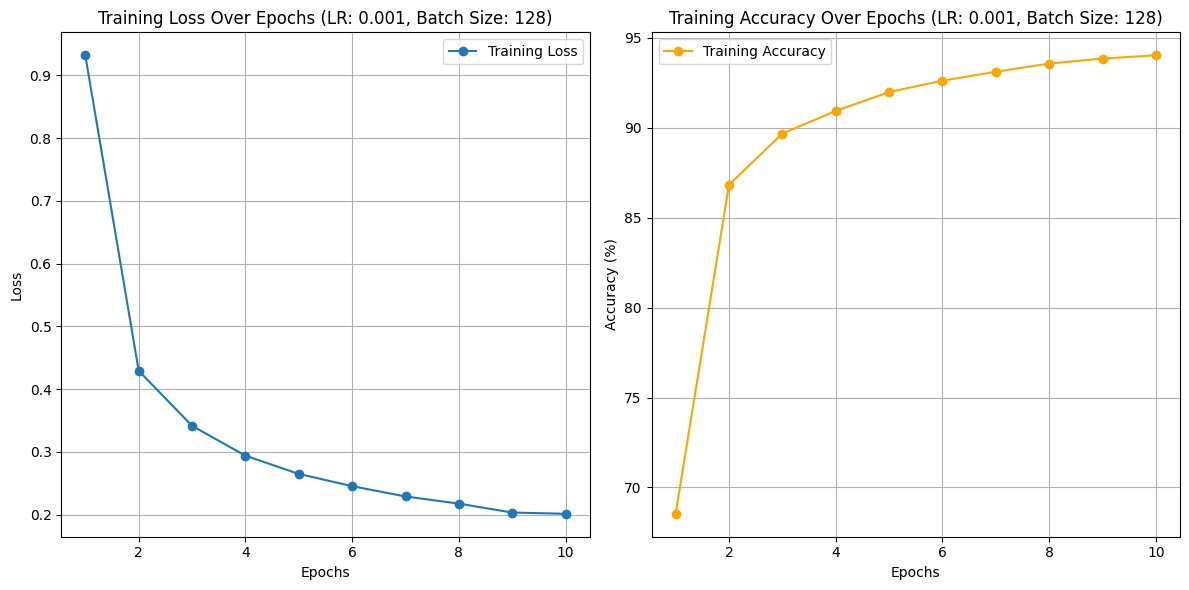

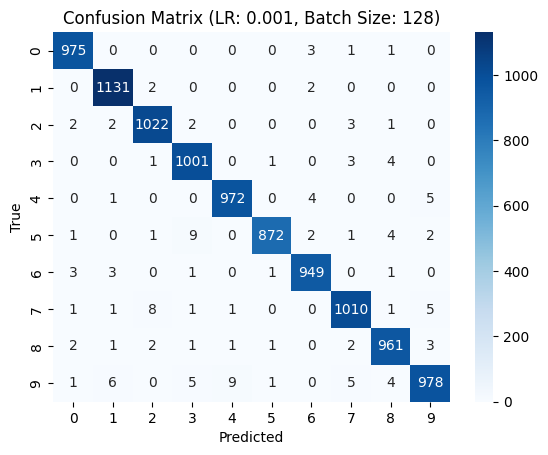

Classification Report (LR: 0.001, Batch Size: 128):
              precision    recall  f1-score   support

           0  0.98984772 0.99489796 0.99236641       980
           1  0.98777293 0.99647577 0.99210526      1135
           2  0.98648649 0.99031008 0.98839458      1032
           3  0.98137255 0.99108911 0.98620690      1010
           4  0.98880977 0.98981670 0.98931298       982
           5  0.99543379 0.97757848 0.98642534       892
           6  0.98854167 0.99060543 0.98957247       958
           7  0.98536585 0.98249027 0.98392596      1028
           8  0.98362334 0.98665298 0.98513583       974
           9  0.98489426 0.96927651 0.97702298      1009

    accuracy                      0.98710000     10000
   macro avg  0.98721483 0.98691933 0.98704687     10000
weighted avg  0.98711379 0.98710000 0.98708723     10000

Best Hyperparameters -> Learning Rate: 0.001, Batch Size: 32
Best Test Accuracy: 99.04%


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2)
        x = self.dropout(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64, 128]
epochs = 10

# Data Transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets and Data Loaders
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

results = []

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    return 100 * correct / total, all_labels, all_preds

for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    print(f"Training with Learning Rate: {lr}, Batch Size: {batch_size}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = LeNet5().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    test_accuracy, all_labels, all_preds = evaluate_model(model, test_loader)
    results.append((lr, batch_size, test_accuracy))
    print(f"Test Accuracy: {test_accuracy:.2f}%\n")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.title(f'Training Loss Over Epochs (LR: {lr}, Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='orange', label='Training Accuracy')
    plt.title(f'Training Accuracy Over Epochs (LR: {lr}, Batch Size: {batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion Matrix and Classification Report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (LR: {lr}, Batch Size: {batch_size})')
    plt.show()

    print(f"Classification Report (LR: {lr}, Batch Size: {batch_size}):")
    print(classification_report(all_labels, all_preds, digits=8))

best_result = max(results, key=lambda x: x[2])
print(f"Best Hyperparameters -> Learning Rate: {best_result[0]}, Batch Size: {best_result[1]}")
print(f"Best Test Accuracy: {best_result[2]:.2f}%")

Mounted at /content/drive
Found 5 images.


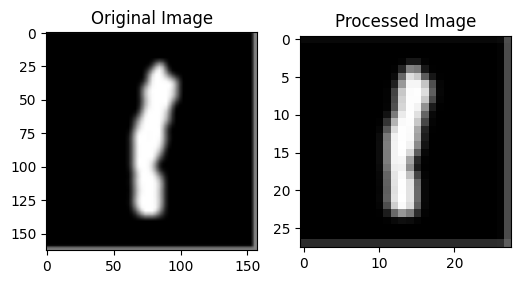

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105309.png, Predicted Class: 1


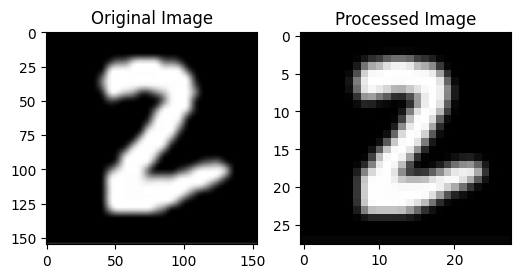

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105316.png, Predicted Class: 2


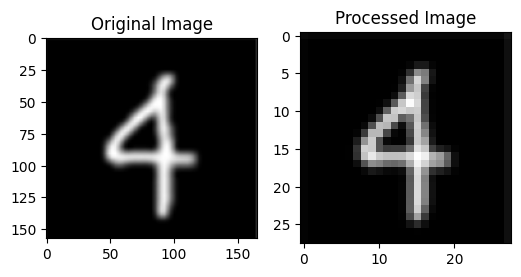

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105322.png, Predicted Class: 4


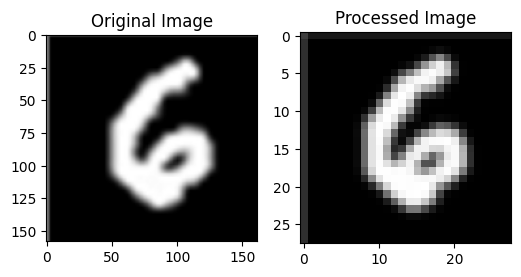

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105425.png, Predicted Class: 6


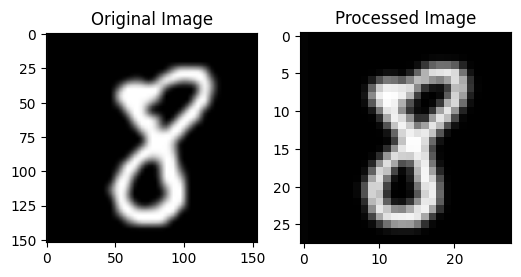

Image: /content/drive/My Drive/test_images/Screenshot 2025-01-02 105434.png, Predicted Class: 8


In [3]:
from google.colab import drive
import os
import cv2
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Mount Google Drive
drive.mount('/content/drive')

# Define test images folder path
test_images_folder = '/content/drive/My Drive/test_images'

# Load all image file paths
image_files = [os.path.join(test_images_folder, f) for f in os.listdir(test_images_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
print(f"Found {len(image_files)} images.")

# Define normalization techniques
normalization_options = {
    'zero_one': transforms.Normalize((0.0,), (1.0,)),  # Scale [0, 1]
    'minus_one_one': transforms.Normalize((0.5,), (0.5,)),  # Scale [-1, 1]
    'mean_std': transforms.Normalize((0.5,), (0.25,))  # Custom mean and std deviation
}

# Choose the normalization technique
selected_normalization = normalization_options['minus_one_one']  # Change this to test others

# Define transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    selected_normalization
])

# Function to test a single image
def test_single_image(image_path, model, transform):
    # Set model to evaluation mode
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    original_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Apply transformations
    processed_image = transform(image).unsqueeze(0).to(device)

    # Display original and processed images
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(processed_image.squeeze().cpu().numpy(), cmap='gray')
    plt.title("Processed Image")
    plt.show()

    # Perform inference
    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)

    return original_image, predicted.item()

# Loop through and test each image
model.eval()
for image_path in image_files:
    original_image, predicted_class = test_single_image(image_path, model, transform)
    print(f"Image: {image_path}, Predicted Class: {predicted_class}")
